In [166]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

### TODO:
- [X] Table of Contents, 
- [ ] Narrative
- [ ] Drop rows with multiple missing values, esply lat/lon
- [ ] Import formation tops, recaluclate target formation
- [ ] Detect anomalies and impute production for young wells


# Table of contents
1. [Introduction](#introduction)
1. [Import data](#paragraph1)
    1. [Data Dict](#subparagraph1)
    1. [Data Summary](#subparagraph2)
1. [Categorical Features](#paragraph2)
1. [Continuous Features](#paragraph3)
1. [Examining the Target](#paragraph4)
1. [Spatial Analysis](#paragraph5)
1. [Temporal Analysis](#paragraph6)
1. [Preliminary Model_Fitting](#paragraph7)



In [14]:
#pydata
import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor

# display and visualization
pd.options.display.float_format = '{:.2f}'.format
from IPython.core.display import display, HTML, Markdown
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import altair as alt
alt.renderers.enable('notebook')
alt.data_transformers.enable('json')

# custom tools
import sys
sys.path.insert(1, '../scripts/')
# import eda_tools as et
import data_munging_tools as dmt
import model_fitting_tools as mft

## Introduction <a name="introduction"></a>
### Exploring Data

I usually approach EDA in the following way:
1. Summary statistics
    1. Missingness
    1. Cardinality
    1. Measure of Dispersion
    1. How does it (independently) vary with the target?
1. Categorical Variables:
    1. Value Counts and Box Plots with the Target
1. Continuous Variables:
    1. Univariate plots (I like stripplots)
    1. Bivariate plots (I like scattermatrices with groups of variables)
    1. Correlation among continuous features (correlation matrix clustermap)
1. Geographic Analysis (if applicable)
1. Temporal Analysis (if applicable)



### Load data

In [2]:
# `pd.read_html()`  requires packages: lxml, html5lib, beautifulsoup4
data_dict = (pd.read_html('../data/AttributeDescriptions.html')[0]
             .copy()
             .rename(columns=lambda x: x.lower().replace(" ", "_"))
             .assign(field_name=lambda x: x["field_name"].apply(lambda x: x.lower()))
             .set_index("field_name")
             .sort_index()
            )

In [3]:
display(Markdown("### Data Dict"))
data_dict.style.set_properties(subset=['description'], **{'width': '700px'})

### Data Dict

,category,description
field_name,,
api,Identifier,Globally unique identifier for the well
bakken_isopach_ft,Geology,Thickness of the oil producing Bakken formation at the latitude/longitude of the well
bh_lat,Location,Latitude of the 'bottom hole' (the end of the laterally drilled bore)
bh_lng,Location,Longitude of the 'bottom hole' (the end of the laterally drilled bore)
choke_size,nan,Diameter in inches of the mechanical flow limiter
countyname,Location,Name of the County where the well is located
currentoperator,nan,Name of the Company that operates the well
currentwellname,nan,"Name of the well; essentially free text, naming conventions vary by operator"
dfelev,nan,Drilling floor elevation


In [4]:
# Load the dataframes
test_df = pd.read_csv('../data/cleaned-input.test.tsv', sep='\t', low_memory=False)
train_df = pd.read_csv('../data/cleaned-input.training.tsv', sep='\t', low_memory=False)

In [5]:
# Specify some columns for future reference
coord_cols = ["surface_lat", "surface_lng", "bh_lat", "bh_lng"]
target_col = "production_liquid_180"

## Create a dataframe for further inspection
There's actually quite a bit going on here.
I'm doing some basic data munging and feature engineering before even looking at the data.
Three main things are happening:
1. I want a per-foot calculation for many of the completion features, because that gives a true notion of "stimulation intensity"
    1. In order to do so, we need some notion of the lateral length of each well. My function needs a little bit of work, because it seems to be generating null values in many cases.
1. Another thing we can calculate relatively easily is interwell spacing.
1. I also want to normalize choke size.


In [6]:
inspect_df = (train_df.copy()
                      .rename(columns=str.lower)
                      .assign(api = lambda x: x["api"].str.strip("US"))
                      .set_index("api")
                      .sort_index(axis=1)
                      .assign(length=lambda x: dmt.haversine_distance(x["surface_lat"], x["surface_lng"], x["bh_lat"], x["bh_lng"]),
                              prop_per_ft=lambda x: x["total_lbs_proppant"] / x["length"],
                              fluid_per_ft=lambda x: x["total_volume_bbls"]/ x["length"],
                              stage_spacing=lambda x: x["total_num_stages"] / x["length"],
                              choke_size=lambda x: x["choke_size"].apply(lambda x: dmt.parse_choke_size(x)),
                              range_tvd=lambda x: x["max_tvd"] - x["min_tvd"]
                             )
                      .pipe(dmt.find_distance_to_nearest_neighbor, *coord_cols)
             )

In [115]:
# I almost always look at the head and tail of the data first.
display(inspect_df.head(1),
        inspect_df.tail(1)
       )

,bakken_isopach_ft,bh_lat,bh_lng,choke_size,countyname,currentoperator,currentwellname,dfelev,fieldname,fileno,...,well_status_date,wellbore,wellstatus,welltype,length,prop_per_ft,fluid_per_ft,stage_spacing,range_tvd,shortest_dist
api,,,,,,,,,,,,,,,,,,,,,
33105034550000,90.00,48.17,-103.25,0.64,WILLIAMS,WHITING OIL AND GAS CORPORATION,P WOOD 154-98-16-23-14-2H3,nan,TRUAX,27863,...,2014-11-01,HORIZONTAL,A,OG,9450.58,422.37,9.55,0.00,521.04,0.00


,bakken_isopach_ft,bh_lat,bh_lng,choke_size,countyname,currentoperator,currentwellname,dfelev,fieldname,fileno,...,well_status_date,wellbore,wellstatus,welltype,length,prop_per_ft,fluid_per_ft,stage_spacing,range_tvd,shortest_dist
api,,,,,,,,,,,,,,,,,,,,,
33007016960000,40.00,47.30,-103.08,0.41,BILLINGS,"PETRO-HUNT, L.L.C.",ZABOLOTNY 144-98-3A-10-1H,nan,LITTLE KNIFE,21534,...,2012-05-30,HORIZONTAL,A,OG,10357.79,268.25,5.98,0.00,537.21,0.06


In [126]:
df_summary = dmt.make_df_summary(inspect_df, target_col=target_col)
display(df_summary.head())

,dtype,num_unique,perc_missing,mean,std,coeff_var,entropy,min,25%,50%,75%,max,corr_target
column,,,,,,,,,,,,,
fileno,int64,6529,0.00,22461.72,3251.21,0.14,nan,11259.00,19790.00,22516.00,25181.00,29021.00,0.17
num_pools_produced,int64,2,0.00,1.00,0.02,0.02,nan,1.00,1.00,1.00,1.00,2.00,-0.01
section,int64,36,0.00,18.08,10.43,0.58,nan,1.00,9.00,18.00,27.00,36.00,0.00
total_num_stages,int64,74,0.00,25.78,11.05,0.43,nan,1.00,21.00,30.00,31.00,98.00,0.23
bakken_isopach_ft,float64,14,0.00,86.52,24.66,0.28,nan,10.00,70.00,90.00,100.00,140.00,0.15


In [127]:
summary_df = df_summary.join(data_dict)
summary_df["using"] = None
summary_df["notes"] = None
display(summary_df.head())

,dtype,num_unique,perc_missing,mean,std,coeff_var,entropy,min,25%,50%,75%,max,corr_target,category,description,using,notes
column,,,,,,,,,,,,,,,,,
fileno,int64,6529,0.00,22461.72,3251.21,0.14,nan,11259.00,19790.00,22516.00,25181.00,29021.00,0.17,Identifier,North Dakota specific identifier for the well,None,None
num_pools_produced,int64,2,0.00,1.00,0.02,0.02,nan,1.00,1.00,1.00,1.00,2.00,-0.01,NaN,Number of formations that will produce oil for...,None,None
section,int64,36,0.00,18.08,10.43,0.58,nan,1.00,9.00,18.00,27.00,36.00,0.00,Location,"Location of the well (Township, Range, Section...",None,None
total_num_stages,int64,74,0.00,25.78,11.05,0.43,nan,1.00,21.00,30.00,31.00,98.00,0.23,CompletionDesign,Number of stages (segments) the well was stimu...,None,None
bakken_isopach_ft,float64,14,0.00,86.52,24.66,0.28,nan,10.00,70.00,90.00,100.00,140.00,0.15,Geology,Thickness of the oil producing Bakken formatio...,None,None


In [131]:
# summary_df.style.set_properties(subset=['description'], **{'width': '700px'})

In [132]:
summary_df.category.value_counts(dropna=False)

NaN                 29
Location            11
Target              10
CompletionDesign     4
Geology              3
Identifier           1
Name: category, dtype: int64

### Location

In [133]:
summary_df.query("category == 'Location'").filter(["dtype", "num_unique", "perc_missing"])

,dtype,num_unique,perc_missing
column,,,
section,int64,36,0.00
bh_lat,float64,6085,5.10
bh_lng,float64,6172,5.10
surface_lat,float64,6423,0.00
surface_lng,float64,6395,0.00
countyname,object,15,0.00
fieldname,object,333,0.00
leasename,object,3231,0.00
leasenumber,object,4523,0.05


In [134]:
# We don't want to use location data directly.
# The `object` datatyped columns (e.g., `countyname`) are just administrative divisions and not directly relevant to subsurfacegeology.
# We will use lats and lons indirectly perform feature engineering, however.
summary_df.loc[summary_df.category == 'Location', ["using"]] = 0

In [135]:
# The thing we are trying to predict
summary_df.loc[summary_df.category == 'Target', ["using"]] = 0

### Geology

In [136]:
summary_df.query("category == 'Geology'").filter(["dtype", "num_unique", "perc_missing", "description"])

,dtype,num_unique,perc_missing,description
column,,,,
bakken_isopach_ft,float64,14,0.00,Thickness of the oil producing Bakken formatio...
producedpools,object,13,0.17,Which rock formations are producing oil for th...
stimulated_formation,object,14,12.50,Which oil-producing formation was targeted by ...


In [137]:
summary_df.loc['bakken_isopach_ft', "using"] = 1
summary_df.loc[['producedpools', 'stimulated_formation'], "using"] = 0

In [138]:
summary_df.query("category == 'Geology'").filter(["dtype", "num_unique", "perc_missing", "description", "using"])

,dtype,num_unique,perc_missing,description,using
column,,,,,
bakken_isopach_ft,float64,14,0.00,Thickness of the oil producing Bakken formatio...,1
producedpools,object,13,0.17,Which rock formations are producing oil for th...,0
stimulated_formation,object,14,12.50,Which oil-producing formation was targeted by ...,0


### Completion Design Parameters

In [139]:
summary_df[summary_df.category == 'CompletionDesign']

,dtype,num_unique,perc_missing,mean,std,coeff_var,entropy,min,25%,50%,75%,max,corr_target,category,description,using,notes
column,,,,,,,,,,,,,,,,,
total_num_stages,int64,74,0.00,25.78,11.05,0.43,nan,1.00,21.00,30.00,31.00,98.00,0.23,CompletionDesign,Number of stages (segments) the well was stimu...,None,None
total_lbs_proppant,float64,5535,13.34,3150597.26,4340278.14,1.38,nan,0.00,2106280.00,2868235.00,3650808.25,287883716.00,0.19,CompletionDesign,"Total amount of proppant used on completion, a...",None,None
total_volume_bbls,float64,5353,15.07,66247.62,65955.67,1.00,nan,0.00,39364.00,54808.00,76080.00,3069486.00,0.20,CompletionDesign,Total amount of liquid used to pressurize the ...,None,None
type_treatment,object,9,17.18,nan,nan,NaN,0.50,nan,nan,nan,nan,nan,NaN,CompletionDesign,Type of completion applied to this well (commo...,None,None


In [142]:
summary_df.loc[summary_df.category == 'CompletionDesign', "notes"] = "total completion"
summary_df.loc[summary_df.category == 'CompletionDesign', "using"] = 1
summary_df.loc["type_treatment", "using"] = 0
summary_df.loc["type_treatment", "notes"] = "no meaningful variation"
# normalized completion design parameters are useable -- That's why we created them!
summary_df.loc[["prop_per_ft", "shortest_dist", "stage_spacing"], "category"] = "CompletionDesign"
summary_df.loc[["prop_per_ft", "shortest_dist", "stage_spacing"], "notes"] = "normd completion"
summary_df.loc[["prop_per_ft", "shortest_dist", "stage_spacing"], "using"] = 1

In [143]:
summary_df[summary_df.category == 'CompletionDesign']

,dtype,num_unique,perc_missing,mean,std,coeff_var,entropy,min,25%,50%,75%,max,corr_target,category,description,using,notes
column,,,,,,,,,,,,,,,,,
total_num_stages,int64,74,0.00,25.78,11.05,0.43,nan,1.00,21.00,30.00,31.00,98.00,0.23,CompletionDesign,Number of stages (segments) the well was stimu...,1,total completion
prop_per_ft,float64,5333,18.32,960.18,11614.16,12.10,nan,0.28,237.98,313.08,394.32,681189.28,0.02,CompletionDesign,NaN,1,normd completion
shortest_dist,float64,4264,5.10,0.01,0.01,1.34,nan,0.00,0.00,0.01,0.01,0.37,-0.29,CompletionDesign,NaN,1,normd completion
stage_spacing,float64,6196,5.10,0.01,0.11,13.49,nan,0.00,0.00,0.00,0.00,7.34,0.01,CompletionDesign,NaN,1,normd completion
total_lbs_proppant,float64,5535,13.34,3150597.26,4340278.14,1.38,nan,0.00,2106280.00,2868235.00,3650808.25,287883716.00,0.19,CompletionDesign,"Total amount of proppant used on completion, a...",1,total completion
total_volume_bbls,float64,5353,15.07,66247.62,65955.67,1.00,nan,0.00,39364.00,54808.00,76080.00,3069486.00,0.20,CompletionDesign,Total amount of liquid used to pressurize the ...,1,total completion
type_treatment,object,9,17.18,nan,nan,NaN,0.50,nan,nan,nan,nan,nan,NaN,CompletionDesign,Type of completion applied to this well (commo...,0,no meaningful variation


In [150]:
inspect_df.type_treatment.value_counts().to_frame().reset_index().rename(columns={"index": "type_treatment", "type_treatment": "count"})

,type_treatment,count
0,sand frac,4618
1,other,622
2,fracture,158
3,"other,sand frac",3
4,acid,2
5,hydrochloric acid,1
6,"fracture,sand frac",1
7,"hydrochloric acid,sand frac",1
8,"acid,gelled acid",1


### Uncategorized Features

In [151]:
summary_df.query("category != category")

,dtype,num_unique,perc_missing,mean,std,coeff_var,entropy,min,25%,50%,75%,max,corr_target,category,description,using,notes
column,,,,,,,,,,,,,,,,,
num_pools_produced,int64,2,0.00,1.00,0.02,0.02,nan,1.00,1.00,1.00,1.00,2.00,-0.01,NaN,Number of formations that will produce oil for...,None,None
choke_size,float64,62,20.40,0.47,0.19,0.41,nan,0.00,0.34,0.44,0.59,1.00,0.02,NaN,Diameter in inches of the mechanical flow limiter,None,None
dfelev,float64,2,99.97,2452.50,57.28,0.02,nan,2412.00,2432.25,2452.50,2472.75,2493.00,1.00,NaN,Drilling floor elevation,None,None
fluid_per_ft,float64,5219,20.06,19.53,215.35,11.02,nan,0.01,4.38,5.95,8.54,13102.55,0.02,NaN,NaN,None,None
grelev,float64,859,17.43,2258.25,721.84,0.32,nan,204.00,2118.00,2256.00,2347.00,22332.00,-0.04,NaN,Graded elevation,None,None
kbelev,float64,882,6.02,2260.69,183.84,0.08,nan,1520.00,2146.00,2283.00,2372.00,2869.00,-0.15,NaN,Kelly Bushing elevation,None,None
legs,float64,8,5.10,2.21,0.54,0.24,nan,1.00,2.00,2.00,2.00,9.00,-0.05,NaN,Number of disjoint laterally drilled segments,None,None
length,float64,6196,5.10,8482.38,2844.81,0.34,nan,3.95,6665.74,9917.99,10109.08,15759.64,0.08,NaN,NaN,None,None
max_tvd,float64,6100,5.10,10257.88,1126.14,0.11,nan,1315.62,9978.02,10559.12,10902.60,11514.96,0.17,NaN,Maximum vertical depth measurement (along the ...,None,None


In [152]:
meta_cols = ["currentoperator", "current_well_name", "originaloperator", "originalwellname", "well_status", "well_status_date"] 

In [27]:
tvd_cols = summary_df.T.filter(regex="tvd").columns.values

In [28]:
summary_df.loc[tvd_cols, "using"] = 1

In [29]:
summary_df.loc["max_tvd", "using"] = 0
summary_df.loc["max_tvd", "notes"] = "basically the same as `tvd`"

### TVD

In [30]:
summary_df.loc[tvd_cols]

,dtype,num_unique,perc_missing,mean,std,coeff_var,entropy,min,25%,50%,75%,max,corr_target,category,description,using,notes
column,,,,,,,,,,,,,,,,,
max_tvd,float64,6100,5.10,10257.88,1126.14,0.11,nan,1315.62,9978.02,10559.12,10902.60,11514.96,0.17,NaN,Maximum vertical depth measurement (along the ...,0,basically the same as `tvd`
mean_tvd,float64,6196,5.10,10172.30,1136.14,0.11,nan,1259.81,9888.17,10476.15,10825.02,11461.70,0.17,NaN,Mean vertical depth measurement (along the len...,1,None
min_tvd,float64,6112,5.10,9621.95,1195.36,0.12,nan,651.53,9309.34,9924.10,10310.53,11031.20,0.16,NaN,Minimum vertical depth measurement (along the ...,1,None
range_tvd,float64,5883,5.10,635.93,306.00,0.48,nan,0.00,534.47,592.19,667.13,8943.58,-0.01,NaN,NaN,1,None
std_tvd,float64,6196,5.10,130.76,93.09,0.71,nan,0.00,100.10,118.42,142.95,2763.85,-0.03,NaN,Standard deviation of all lateral true vertica...,1,None
tvd,float64,6113,5.10,10231.24,1129.94,0.11,nan,1267.65,9931.41,10527.95,10881.72,11514.96,0.17,NaN,True vertical depth at the deepest part of the...,1,None


 <a name="paragraph2"></a>
# Inspect Categorical Features

In [31]:
cat_df = inspect_df.copy().select_dtypes("O")

In [32]:
for col in cat_df.columns:
    nunique = cat_df[col].nunique()
    display(Markdown(f"### {col}: {nunique}"))
    display(cat_df[col].value_counts().to_frame().head(5))

### countyname: 15

,countyname
MCKENZIE,1796
MOUNTRAIL,1605
WILLIAMS,1081
DUNN,1078
DIVIDE,432


### currentoperator: 56

,currentoperator
WHITING OIL AND GAS CORPORATION,867
"CONTINENTAL RESOURCES, INC.",752
"HESS BAKKEN INVESTMENTS II, LLC",640
XTO ENERGY INC.,431
"EOG RESOURCES, INC.",414


### currentwellname: 6529

,currentwellname
ROLLEFSTAD 2-3H,1
WOLDING 14-24H,1
SALEM 2-6H,1
DIDRICK 4-27HB,1
SERRAHN 41X-6D,1


### fieldname: 333

,fieldname
SANISH,395
PARSHALL,264
ALGER,197
MURPHY CREEK,144
VAN HOOK,127


### footages: 6120

,footages
250 FNL 1320 FWL,13
300 FSL 1320 FEL,12
300 FNL 1320 FEL,12
300 FNL 300 FWL,8
400 FSL 1280 FWL,8


### leasename: 3231

,leasename
FORT BERTHOLD,88
MHA,71
WAYZETTA,45
AUSTIN,37
PARSHALL,32


### leasenumber: 4523

,leasenumber
1-H,67
1,20
1-29H,20
1-22H,20
1-12H,19


### originaloperator: 99

,originaloperator
"CONTINENTAL RESOURCES, INC.",722
WHITING OIL AND GAS CORPORATION,595
HESS CORPORATION,523
"EOG RESOURCES, INC.",414
MARATHON OIL COMPANY,365


### originalwellname: 6527

,originalwellname
P WOOD 154-98-3-27-34-14H,2
ANGUS 2-9H,2
SORENSON 152-96-24C-13-2H,1
HELENA 1-7H,1
JOHNSON 24-31NEH,1


### producedpools: 13

,producedpools
BAKKEN,6310
SANISH,82
SPEARFISH,72
BAKKEN/THREE FORKS,30
SPEARFISH/MADISON,8


### qq: 43

,qq
SWSE,919
SESE,761
SESW,739
NENW,628
NWNE,595


### range: 24

,range
95 W,740
92 W,670
96 W,583
99 W,576
93 W,552


### spud_date: 2133

,spud_date
2014-01-11,12
2013-05-02,12
2014-01-30,11
2013-11-27,11
2013-01-15,11


### stimulated_formation: 14

,stimulated_formation
bakken,3987
three forks,1617
spearfish,85
pronghorn,7
madison,4


### township: 30

,township
152 N,661
153 N,588
155 N,540
154 N,531
151 N,528


### type_treatment: 9

,type_treatment
sand frac,4618
other,622
fracture,158
"other,sand frac",3
acid,2


### well_status_date: 2151

,well_status_date
2012-12-14,15
2013-04-18,13
2013-09-20,12
2014-07-09,12
2014-06-24,12


### wellbore: 3

,wellbore
HORIZONTAL,6519
HORIZONTAL RE-ENTRY,6
DIRECTIONAL,4


### wellstatus: 8

,wellstatus
A,6248
IA,250
TA,7
PA,7
DRL,7


### welltype: 1

,welltype
OG,6529


## Categorical Plots

In [33]:
cat_df = (inspect_df.copy()
                  .select_dtypes("O")
                  .pipe(dmt.drop_hi_lo_card)
                  .pipe(dmt.reduce_cardinality)
         )

cat_cols = cat_df.columns

cat_df = cat_df.join(inspect_df.filter([target_col]))

Shape before cardinality removal: (6529, 20)
Shape after cardinality removal: (6529, 12)


In [131]:
cat_cols

Index(['countyname', 'currentoperator', 'fieldname', 'originaloperator',
       'producedpools', 'qq', 'range', 'stimulated_formation', 'township',
       'type_treatment', 'wellbore', 'wellstatus'],
      dtype='object')

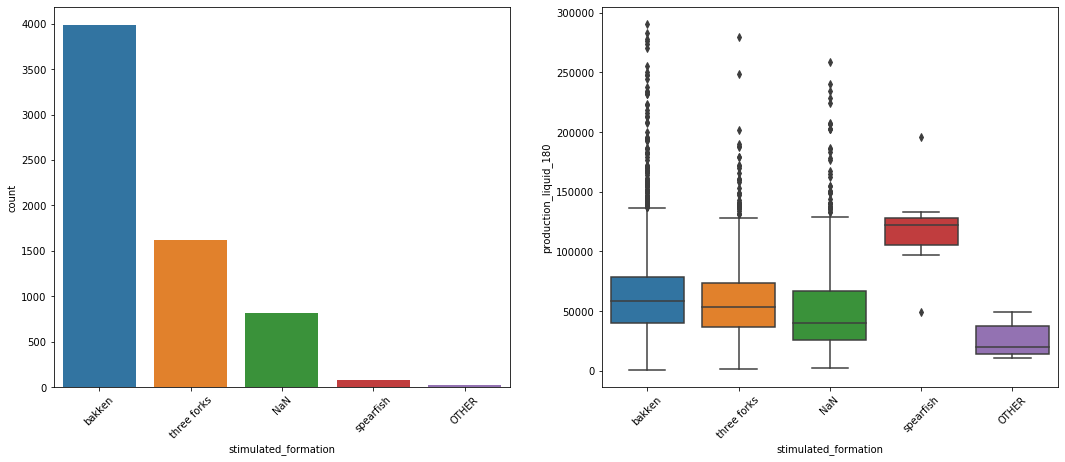

In [36]:
dmt.inspect_cat_plots(cat_df, "stimulated_formation", target_col)

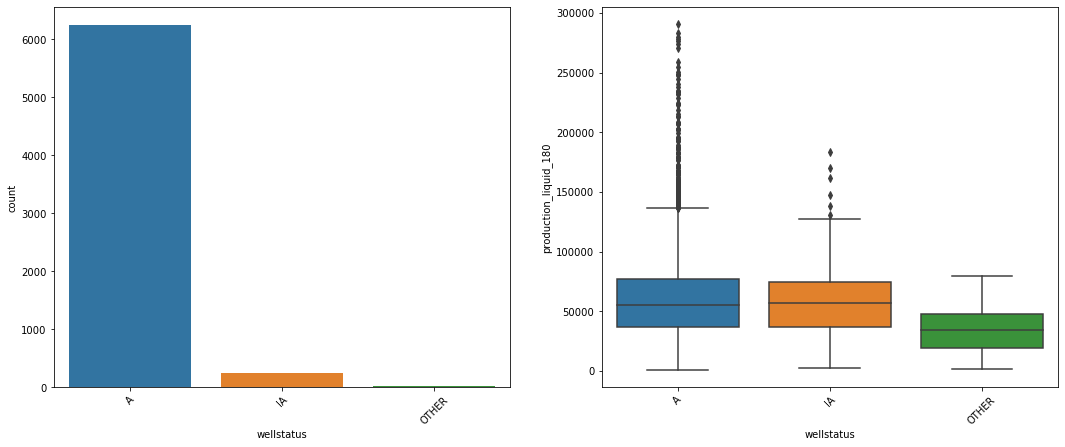

In [154]:
dmt.inspect_cat_plots(cat_df, "wellstatus", target_col)

# Inspect Continuous Features  <a name="paragraph3"></a>

In [155]:
foi = sorted([
'total_lbs_proppant',
'total_num_stages', 
'total_volume_bbls',
'length',
'legs',
'prop_per_ft',
'fluid_per_ft', 
'stage_spacing', 
'mean_tvd',
'bakken_isopach_ft',
'choke_size',
'shortest_dist'
])

total_cols = sorted([
'total_lbs_proppant',
'total_num_stages', 
'total_volume_bbls',
'length',
])

normd_cols = sorted([
'prop_per_ft',
'fluid_per_ft', 
'stage_spacing'
])

other = sorted([
'mean_tvd',
'bakken_isopach_ft' 
])

In [156]:
cont_df = (inspect_df.copy()
                   .select_dtypes("number")
                   .filter(foi)
                   .sort_index(axis=1)
          )

In [157]:
cont_df.shape

(6529, 12)

In [158]:
cont_df.columns

Index(['bakken_isopach_ft', 'choke_size', 'fluid_per_ft', 'legs', 'length',
       'mean_tvd', 'prop_per_ft', 'shortest_dist', 'stage_spacing',
       'total_lbs_proppant', 'total_num_stages', 'total_volume_bbls'],
      dtype='object')

## Setting outliers to NaN

In [159]:
thresh_dict = defaultdict(lambda: {"min": 0, "max": float("inf")})
thresh_dict["total_lbs_proppant"]["max"] = 20000000.0
thresh_dict["total_volume_bbls"]["max"] = 500000.0
thresh_dict["length"]["min"] = 2000
thresh_dict["mean_tvd"]["min"] = 4000
thresh_dict["total_num_stages"]["min"] = 5

In [160]:
cont_df.head()

,bakken_isopach_ft,choke_size,fluid_per_ft,legs,length,mean_tvd,prop_per_ft,shortest_dist,stage_spacing,total_lbs_proppant,total_num_stages,total_volume_bbls
api,,,,,,,,,,,,
33105034550000,90.00,0.64,9.55,2.00,9450.58,10868.58,422.37,0.00,0.00,3991618.00,20,90232.00
33053034020000,50.00,0.31,6.88,2.00,10073.98,10724.27,364.13,0.03,0.00,3668254.00,38,69347.00
33061026020000,110.00,0.50,6.16,2.00,7544.78,9830.27,403.74,0.01,0.01,3046163.00,46,46463.00
33089007540000,40.00,0.75,5.50,2.00,10043.79,10242.21,479.04,0.01,0.00,4811400.00,30,55196.00
33061021060000,90.00,0.28,nan,2.00,9867.18,9706.36,nan,0.00,0.00,nan,30,nan


In [161]:
cont_df.shape

(6529, 12)

In [162]:
num_missing = inspect_df[foi + coord_cols].isnull().sum(axis=1).sort_values(ascending=False)

In [163]:
num_missing.head()

api
33053059160000    12
33089005680000    12
33053060140000    12
33053059140000    11
33007015830000    11
dtype: int64

{'min': 0, 'max': 500000.0}
987


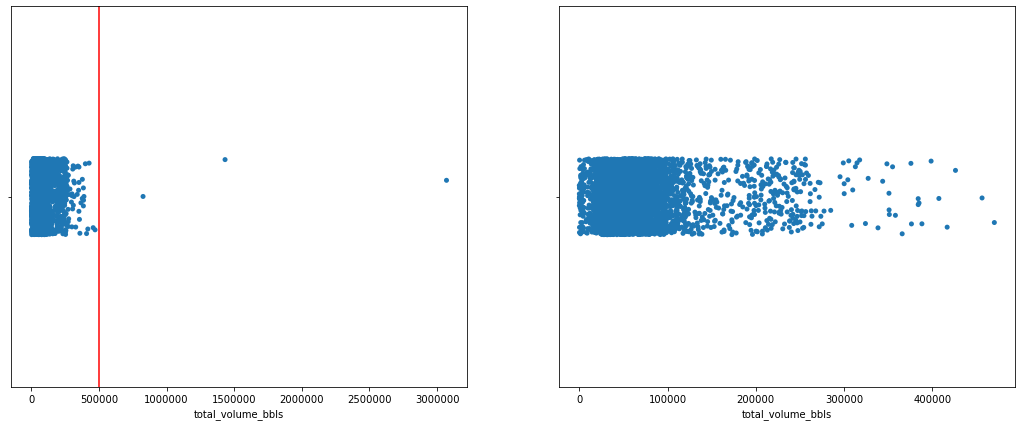

In [164]:
dmt.make_strip_plots(cont_df, "total_volume_bbls", thresh_dict)

{'min': 4000, 'max': inf}
407


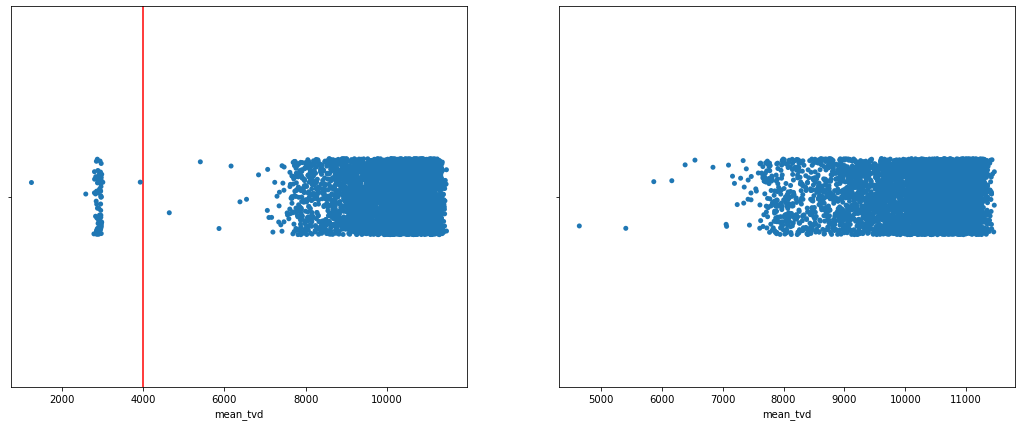

In [165]:
dmt.make_strip_plots(cont_df, "mean_tvd", thresh_dict)

{'min': 5, 'max': inf}
601


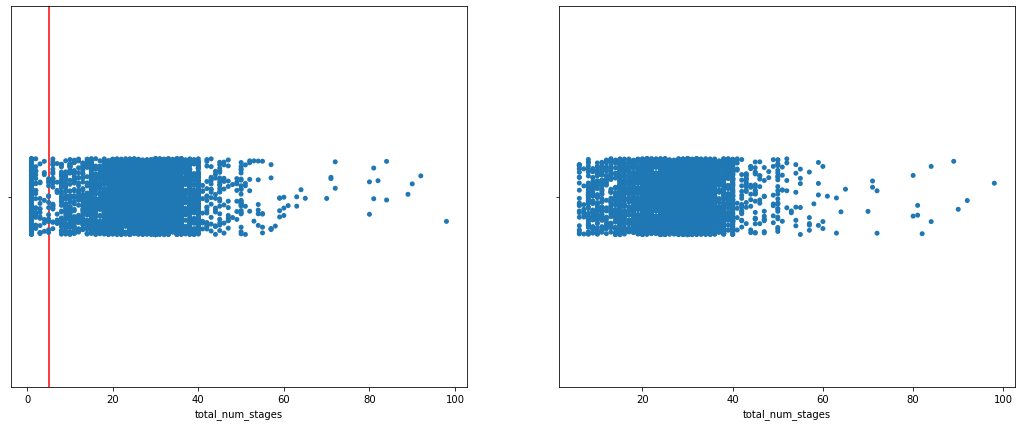

In [50]:
dmt.make_strip_plots(cont_df, "total_num_stages", thresh_dict)

### Examining Target

In [96]:
display(Markdown("### 224 wells in the training set are missing target values at IP 180"))
inspect_df.query(f"{target_col} != {target_col}").shape

### 224 wells are missing target values at IP 180

(224, 57)

In [102]:
display(Markdown("### 54 wells in the test set are missing target values at IP 180"))
test_df.query(f"{target_col} != {target_col}").shape

### 54 wells in the test set are missing target values at IP 180

(54, 53)

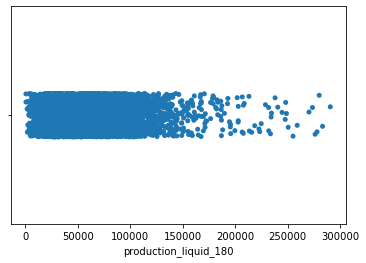

In [28]:
sns.stripplot(inspect_df[target_col])

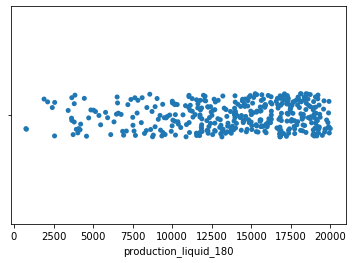

In [29]:
# looking at the low producers
sns.stripplot(inspect_df.query(f"{target_col} < 20000")[target_col])

In [30]:
inspect_df.copy().query(f"stimulated_formation == 'spearfish' & {target_col} < 50000")

,bakken_isopach_ft,bh_lat,bh_lng,choke_size,countyname,currentoperator,currentwellname,dfelev,fieldname,fileno,...,type_treatment,well_status_date,wellbore,wellstatus,welltype,length,prop_per_ft,fluid_per_ft,stage_spacing,shortest_dist
api,,,,,,,,,,,,,,,,,,,,,
33023005710000,100.0,48.895947,-103.4372,0.5625,DIVIDE,SAMSON RESOURCES COMPANY,NESS 29-32-163-98H,NaN,BLOOMING PRAIRIE,18429,...,sand frac,2010-05-17,HORIZONTAL,A,OG,9815.695643,328.12244,5.728886,0.003056,0.018498


In [39]:
tvd_cols = inspect_df.filter(regex="tvd").columns.values.tolist()

### Comparing Depth Measurements

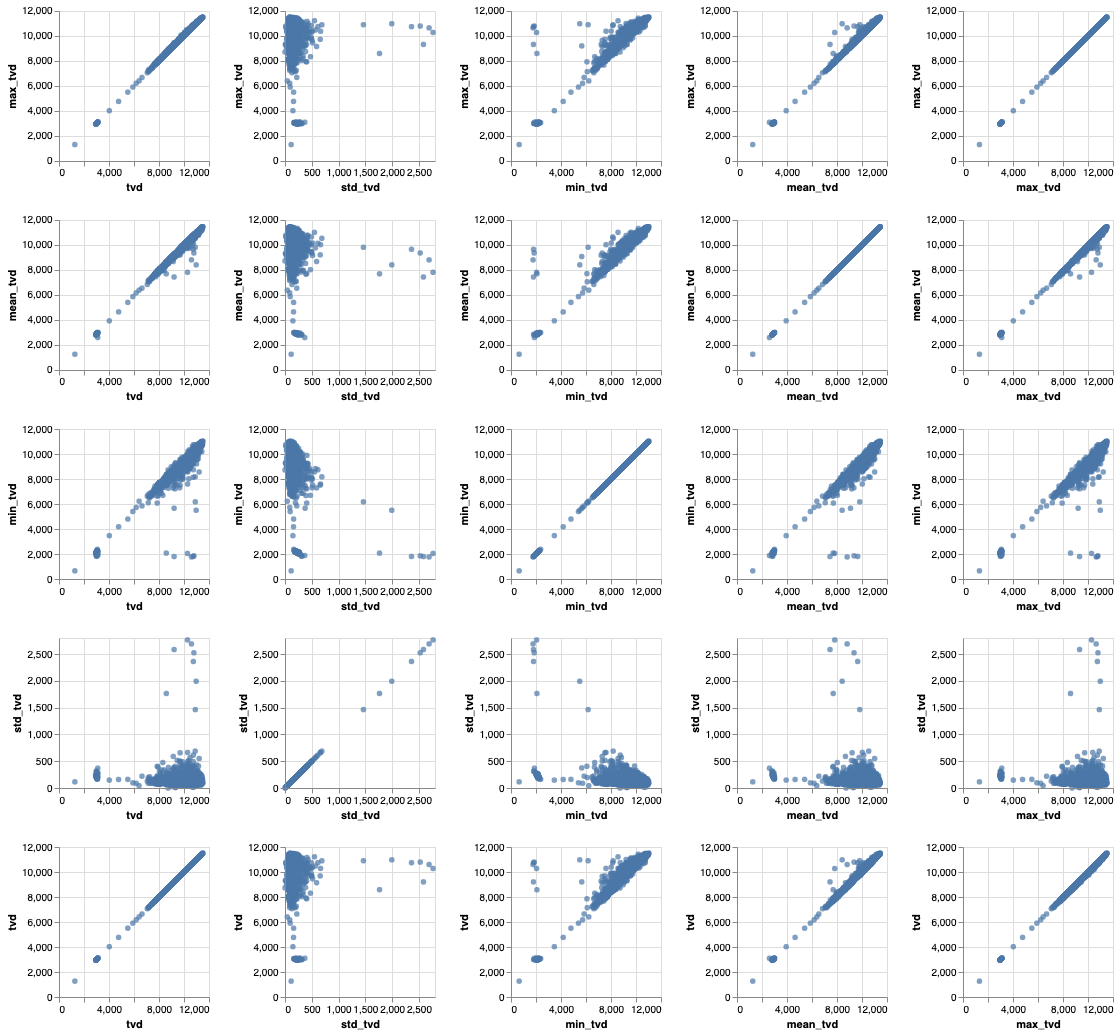

In [43]:
display(Markdown("### Comparing Depth Measurements"))
alt.Chart(inspect_df[tvd_cols]).mark_circle().encode(
    alt.X(alt.repeat("column"), type='quantitative'),
    alt.Y(alt.repeat("row"), type='quantitative'),
).properties(
    width=150,
    height=150
).repeat(
    row=tvd_cols,
    column=tvd_cols[::-1]
)

In [53]:
clean_df = (inspect_df.copy()
                   .pipe(dmt.remove_outiers, thresh_dict)
                    .assign(prop_per_ft=lambda x: x["total_lbs_proppant"] / x["length"],
                            fluid_per_ft=lambda x: x["total_volume_bbls"]/ x["length"],
                            stage_spacing=lambda x: x["total_num_stages"] / x["length"]
                            )
           )

total_lbs_proppant
total_volume_bbls
length
mean_tvd
total_num_stages


### Comparing Total Measurements (After scrubbing outliers)

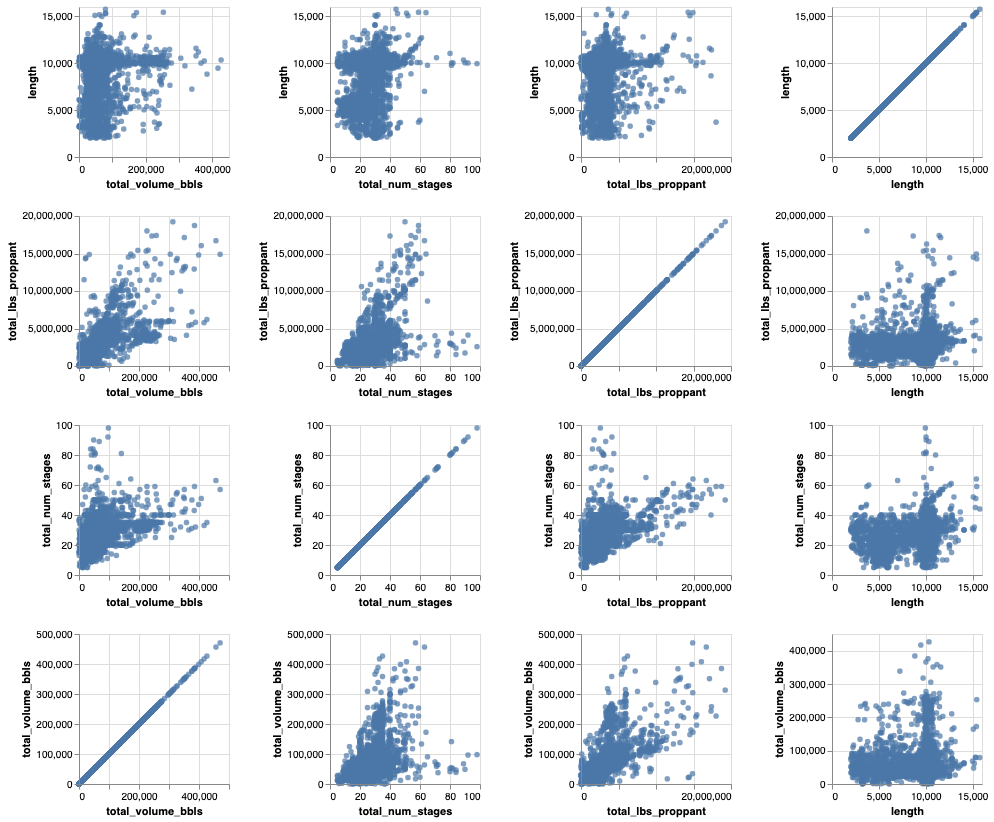

In [54]:
display(Markdown("### Comparing Total Measurements (After scrubbing outliers)"))
alt.Chart(clean_df[total_cols]).mark_circle().encode(
    alt.X(alt.repeat("column"), type='quantitative'),
    alt.Y(alt.repeat("row"), type='quantitative'),
).properties(
    width=150,
    height=150
).repeat(
    row=total_cols,
    column=total_cols[::-1]
)

### Comparing Normalized Measurements (After scrubbing outliers)

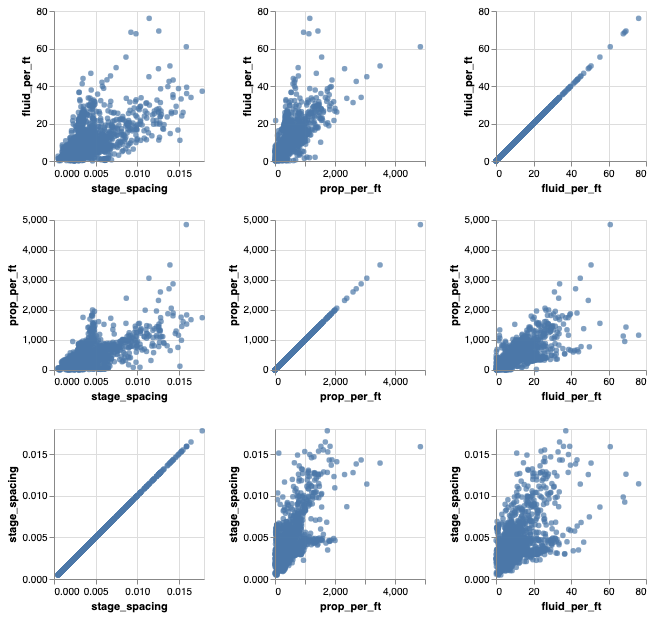

In [55]:
display(Markdown("### Comparing Normalized Measurements (After scrubbing outliers)"))
alt.Chart(clean_df).mark_circle().encode(
    alt.X(alt.repeat("column"), type='quantitative'),
    alt.Y(alt.repeat("row"), type='quantitative'),
#     color='Origin:N'
).properties(
    width=150,
    height=150
).repeat(
    row=normd_cols,
    column=normd_cols[::-1]
)

### Correlation Matrix Heatmap, with Hierarchical Clustering

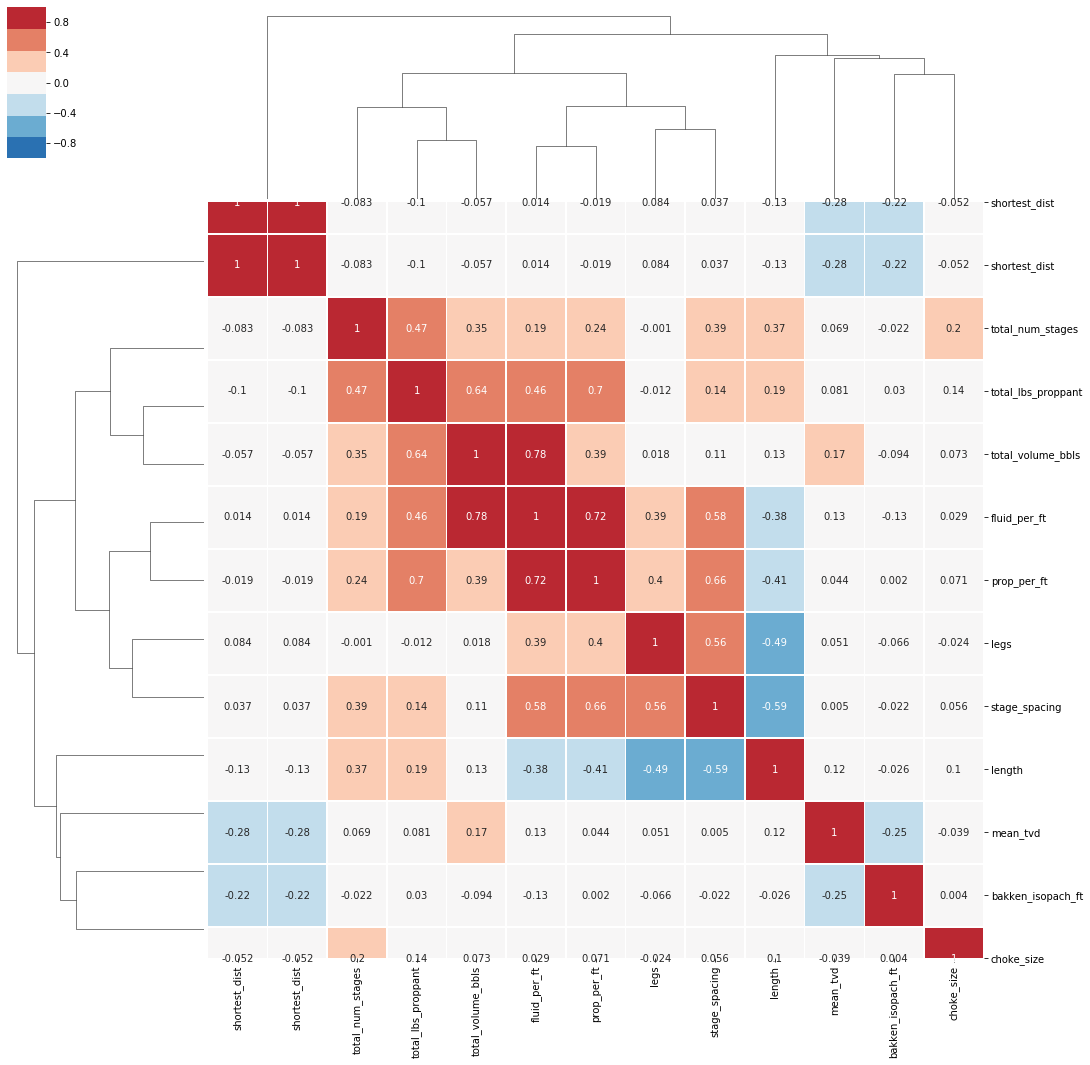

In [58]:
corr_df = clean_df.filter(foi + ["shortest_dist"]).corr().round(3)

display(Markdown("### Correlation Matrix Heatmap, with Hierarchical Clustering"))
sns.clustermap(data=corr_df, 
                    cmap=sns.color_palette("RdBu_r", 7), 
                    linewidths=.5, 
                    vmin=-1, vmax=1, 
                    annot=True)
fig = plt.gcf()  # or by other means, like plt.subplots
figsize = fig.get_size_inches()
fig.set_size_inches(figsize * 1.75)  # scale current size by 1.5

<a name="paragraph5"></a>
# Maps

In [59]:
map_df = (inspect_df.copy()
                      .filter(["surface_lng", "surface_lat", "mean_tvd", target_col, "stimulated_formation", "township", "countyname"])
                      .assign(township = lambda x: x["township"].dropna().apply(lambda x: int(x.split(" ")[0])))
                      .join(cat_df, lsuffix="_orig")
         )

### Where are highest producing wells?

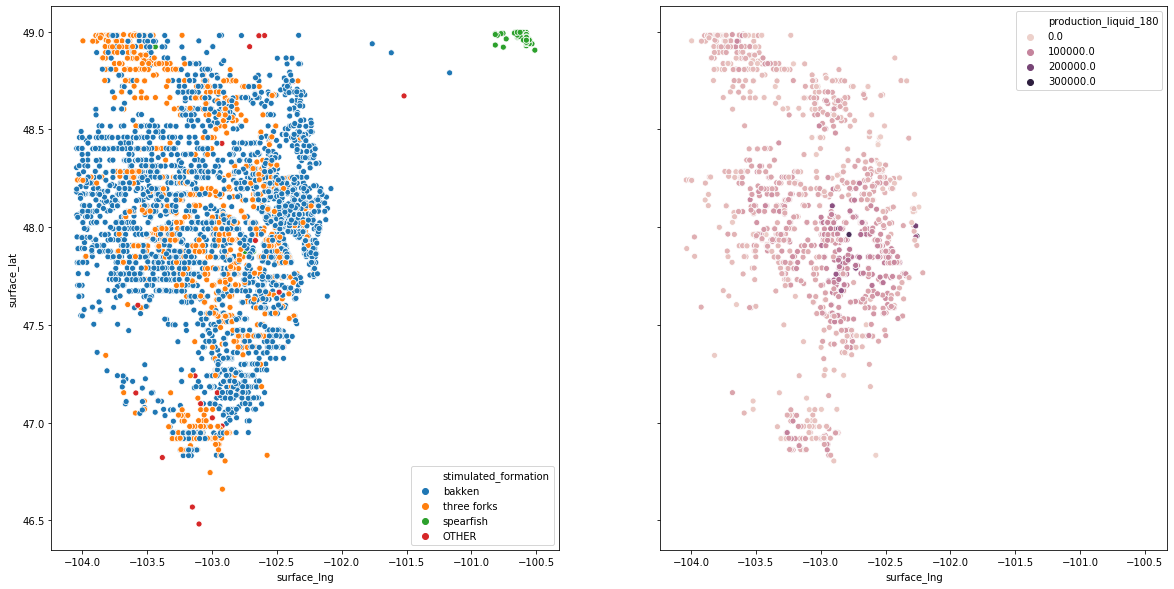

In [60]:
display(Markdown("### Where are highest producing wells?"))
fig, ax = plt.subplots(1, 2, figsize=(20,10), sharex=True, sharey=True)
sns.scatterplot(data=map_df, x="surface_lng", y="surface_lat", hue="stimulated_formation", ax=ax[0])
sns.scatterplot(data=map_df.query("stimulated_formation == 'three forks'"), x="surface_lng", y="surface_lat", hue=target_col, ax=ax[1])
plt.show()

### Political Geography: County and Township

township is basically just degrees latitude


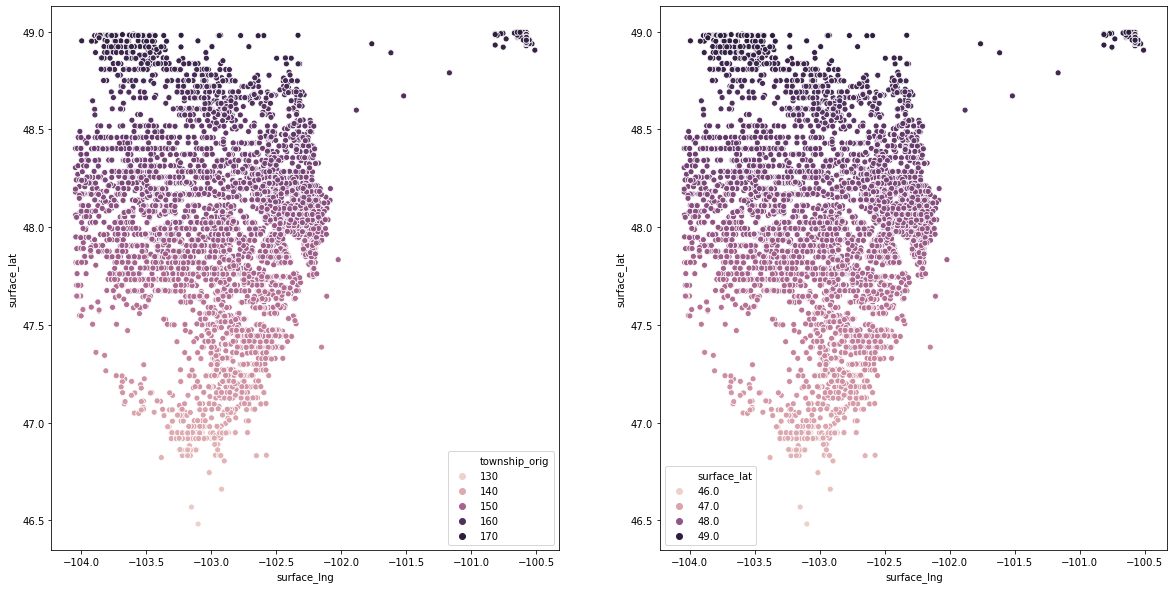

In [62]:
print("township is basically just degrees latitude")
fig, ax = plt.subplots(1, 2, figsize=(20,10))
sns.scatterplot(data=map_df, x="surface_lng", y="surface_lat", hue="township_orig", ax=ax[0])
sns.scatterplot(data=map_df, x="surface_lng", y="surface_lat", hue="surface_lat", ax=ax[1])

plt.show()

County is also just an administrative division, not a meaningful proxy for underlying geology.


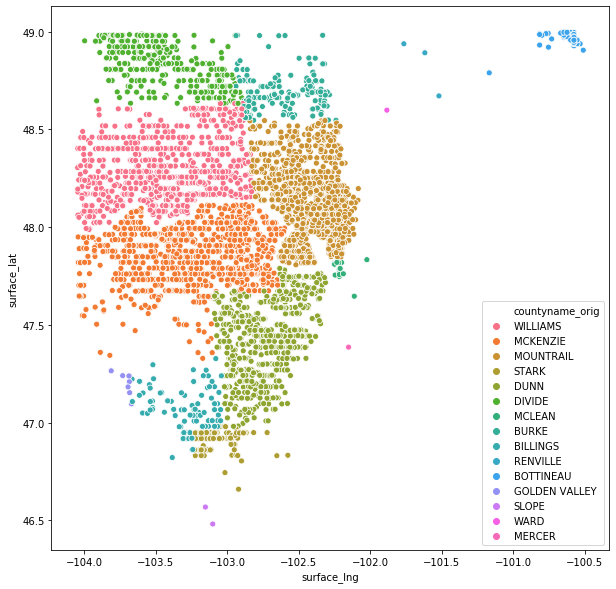

In [63]:
print("County is also just an administrative division, not a meaningful proxy for underlying geology.")
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(data=map_df, x="surface_lng", y="surface_lat", hue="countyname_orig")
plt.show()

### Target Formation and TVD

There is a group of wells in the NE corner are all much shallower. On the edge of the bowl.


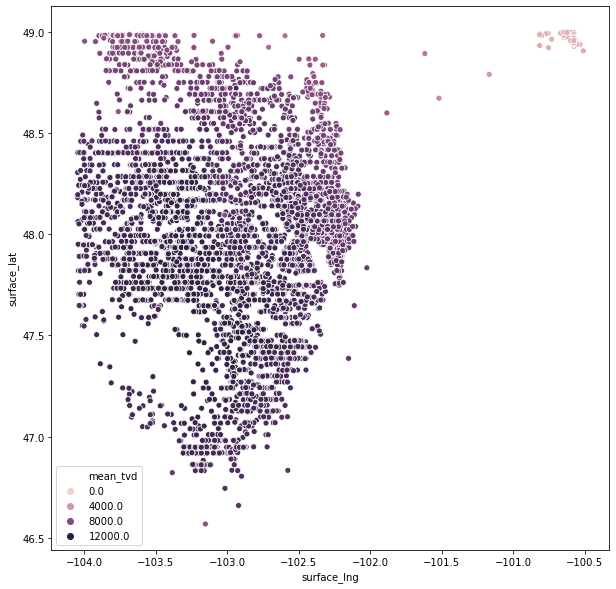

In [64]:
print("There is a group of wells in the NE corner are all much shallower. On the edge of the bowl.")
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(data=map_df, x="surface_lng", y="surface_lat", hue="mean_tvd")
plt.show()

Value Counts of Target Formation

bakken         3987
three forks    1617
NaN             816
spearfish        85
OTHER            24
Name: stimulated_formation, dtype: int64

### Well Map, Colored and Faceted by Target Formation

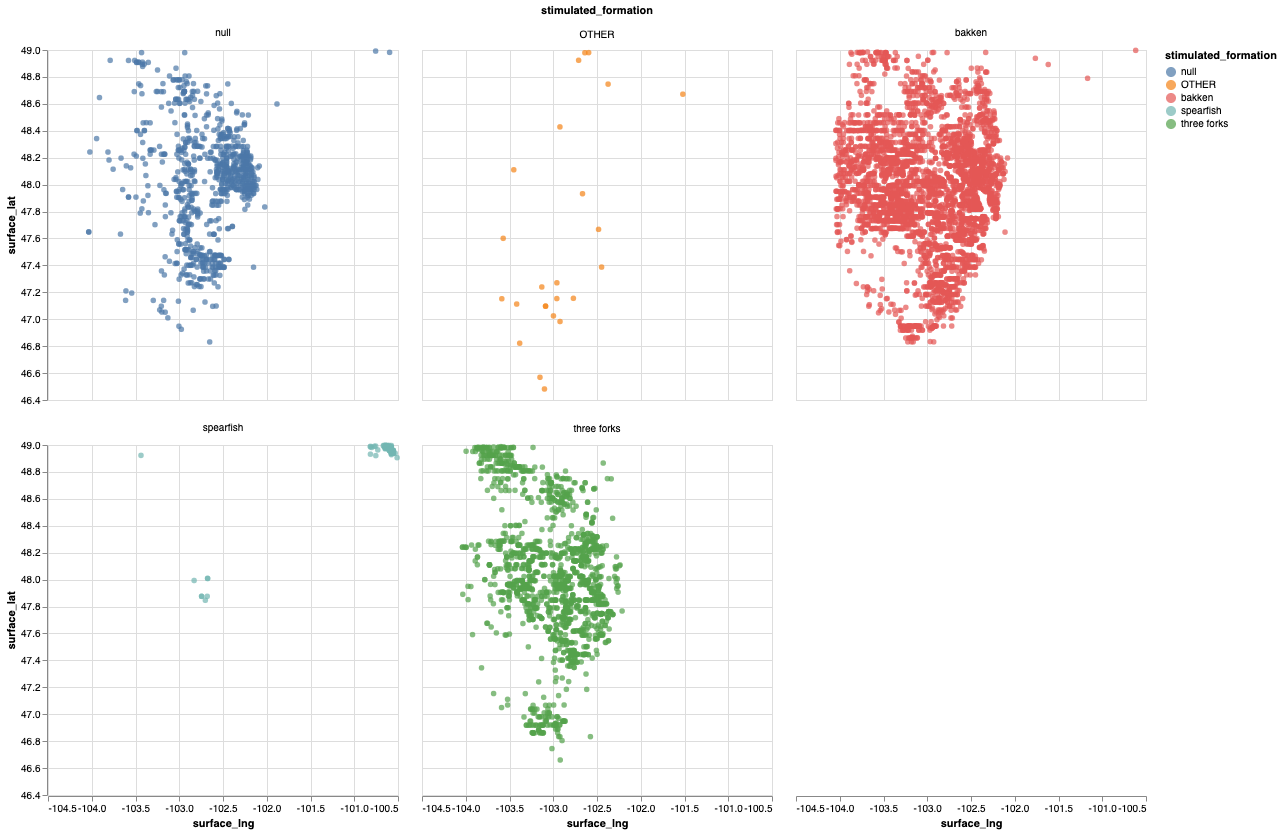

In [65]:
display(Markdown("Value Counts of Target Formation"),
        map_df.stimulated_formation.value_counts(dropna=False),
Markdown("### Well Map, Colored and Faceted by Target Formation"))
alt.Chart(map_df).mark_circle().encode(
    alt.X('surface_lng:Q',
        scale=alt.Scale(zero=False)
    ),
    alt.Y('surface_lat:Q',
        scale=alt.Scale(zero=False)
    ),
    color='stimulated_formation:N',
#     column='stimulated_formation:N'
).properties(
    width=350,
    height=350
).facet(
    facet='stimulated_formation:N',
    columns=3
)

In [66]:
# all of those wells in the NE corner have no production data
inspect_df.query("surface_lng > -101.5").filter(regex="production").notnull().sum()

production_liquid_120     0
production_liquid_150     0
production_liquid_180     0
production_liquid_1825    0
production_liquid_270     0
production_liquid_30      0
production_liquid_365     0
production_liquid_60      0
production_liquid_730     0
production_liquid_90      0
dtype: int64

In [67]:
# Spearfish wells not in the NE corner have no production data
print(inspect_df.query("surface_lng < -101.5 & stimulated_formation == 'spearfish'").shape[0])
inspect_df.query("surface_lng < -101.5 & stimulated_formation == 'spearfish'").filter(regex="production").notnull().sum()

8


production_liquid_120     8
production_liquid_150     8
production_liquid_180     8
production_liquid_1825    0
production_liquid_270     5
production_liquid_30      8
production_liquid_365     5
production_liquid_60      8
production_liquid_730     1
production_liquid_90      8
dtype: int64

Overall distribution of stimulated formation:


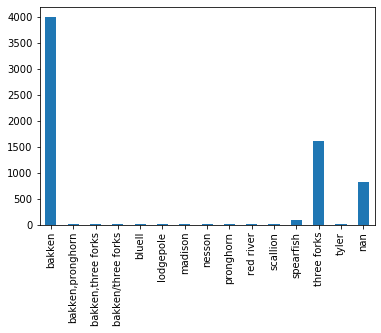

In [68]:
print("Overall distribution of stimulated formation:")
inspect_df.filter(["stimulated_formation"]).squeeze().value_counts(dropna=False).sort_index().plot.bar()
plt.show()

Spearfish wells account for a disproportionate number of missing values. Are they too young (recently drilled)?


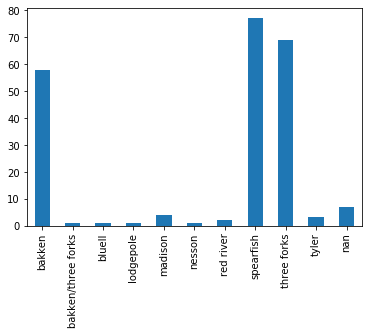

In [69]:
print("Spearfish wells account for a disproportionate number of missing values. Are they too young (recently drilled)?")
inspect_df.query(f"{target_col} != {target_col}").filter(["stimulated_formation"]).squeeze().value_counts(dropna=False).sort_index().plot.bar()

In [70]:
inspect_df.query(f"{target_col} != {target_col}").shape

(224, 58)

### 90% of Spearfish wells are missing, including all of those in the NE corner

In [71]:
spearfish_df = inspect_df.query("stimulated_formation == 'spearfish'")

In [72]:
spearfish_df.filter(["surface_lng", "surface_lat", "mean_tvd", "length", "stimulated_formation", target_col]).head()

,surface_lng,surface_lat,mean_tvd,length,stimulated_formation,production_liquid_180
api,,,,,,
33009023080000,-100.58,48.93,2913.61,4418.78,spearfish,nan
33009023140000,-100.66,49.00,2809.16,3194.00,spearfish,nan
33053036240000,-102.70,47.85,10835.37,10464.99,spearfish,133156.00
33009022810000,-100.62,48.99,2897.54,3228.82,spearfish,nan
33009022530000,-100.58,48.96,2955.93,4468.18,spearfish,nan


In [73]:
display((spearfish_df.filter(regex="production_liquid").isnull().sum() / spearfish_df.shape[0] * 100).to_frame())

,0
production_liquid_120,90.59
production_liquid_150,90.59
production_liquid_180,90.59
production_liquid_1825,100.00
production_liquid_270,94.12
production_liquid_30,90.59
production_liquid_365,94.12
production_liquid_60,90.59
production_liquid_730,98.82
production_liquid_90,90.59


### Visualize distance to nearest neighbor

Seems like it worked


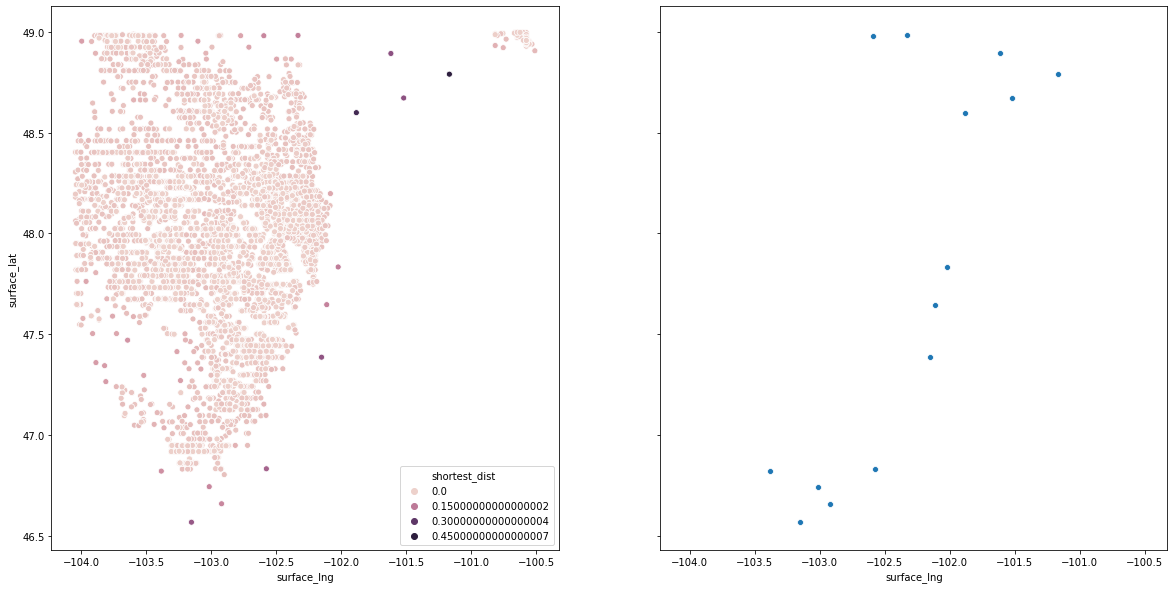

In [74]:
print("Seems like it worked")
fig, ax = plt.subplots(1, 2, figsize=(20,10), sharex=True, sharey=True)
sns.scatterplot(data=inspect_df, x="surface_lng", y="surface_lat", hue="shortest_dist", ax=ax[0])
sns.scatterplot(data=inspect_df.query("shortest_dist > .1"), x="surface_lng", y="surface_lat", ax=ax[1])
plt.show()

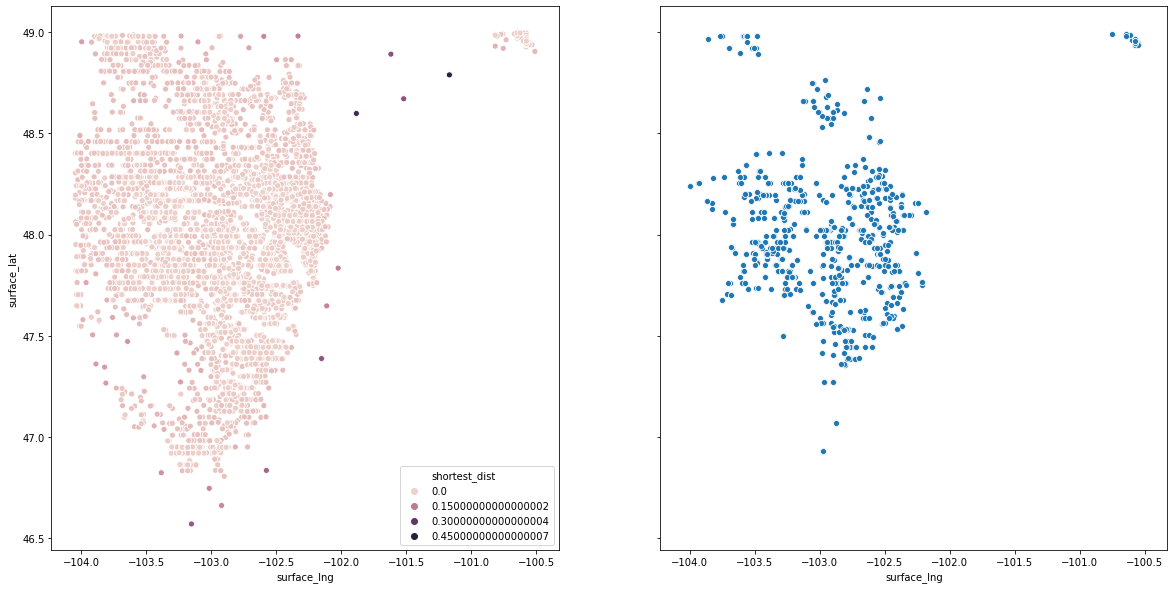

In [75]:
# The most densely spaced wells
fig, ax = plt.subplots(1, 2, figsize=(20,10), sharex=True, sharey=True)
sns.scatterplot(data=inspect_df, x="surface_lng", y="surface_lat", hue="shortest_dist", ax=ax[0])
sns.scatterplot(data=inspect_df.query("shortest_dist < .002"), x="surface_lng", y="surface_lat", ax=ax[1])
plt.show()

<a name="paragraph6"></a>
# Temporal Analysis

## Frac Year

In [76]:
date_df = (inspect_df.copy()
                      .assign(spud_year=lambda x: x["spud_date"].dropna().apply(lambda x: int(x.split("-")[0])))
          )

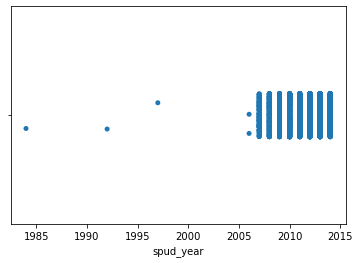

In [77]:
sns.stripplot(date_df.spud_year)

In [78]:
date_df.head()

,bakken_isopach_ft,bh_lat,bh_lng,choke_size,countyname,currentoperator,currentwellname,dfelev,fieldname,fileno,...,wellbore,wellstatus,welltype,length,prop_per_ft,fluid_per_ft,stage_spacing,range_tvd,shortest_dist,spud_year
api,,,,,,,,,,,,,,,,,,,,,
33105034550000,90.00,48.17,-103.25,0.64,WILLIAMS,WHITING OIL AND GAS CORPORATION,P WOOD 154-98-16-23-14-2H3,nan,TRUAX,27863,...,HORIZONTAL,A,OG,9450.58,422.37,9.55,0.00,521.04,0.00,2014.00
33053034020000,50.00,47.91,-103.80,0.31,MCKENZIE,"HESS BAKKEN INVESTMENTS II, LLC",IVERSON TRUST 1-1H,nan,GLASS BLUFF,20136,...,HORIZONTAL,A,OG,10073.98,364.13,6.88,0.00,641.80,0.03,2011.00
33061026020000,110.00,48.21,-102.42,0.50,MOUNTRAIL,"LIME ROCK RESOURCES III-A, L.P.",CGB 30-31H,nan,STANLEY,25780,...,HORIZONTAL,A,OG,7544.78,403.74,6.16,0.01,716.87,0.01,2013.00
33089007540000,40.00,46.89,-102.97,0.75,STARK,WHITING OIL AND GAS CORPORATION,PAVLISH 31-30PH,nan,SOUTH HEART,24575,...,HORIZONTAL,A,OG,10043.79,479.04,5.50,0.00,564.90,0.01,2013.00
33061021060000,90.00,48.23,-102.38,0.28,MOUNTRAIL,"LIME ROCK RESOURCES III-A, L.P.",STATE 34-33-28H,nan,STANLEY,22752,...,HORIZONTAL,A,OG,9867.18,nan,nan,0.00,474.67,0.00,2012.00


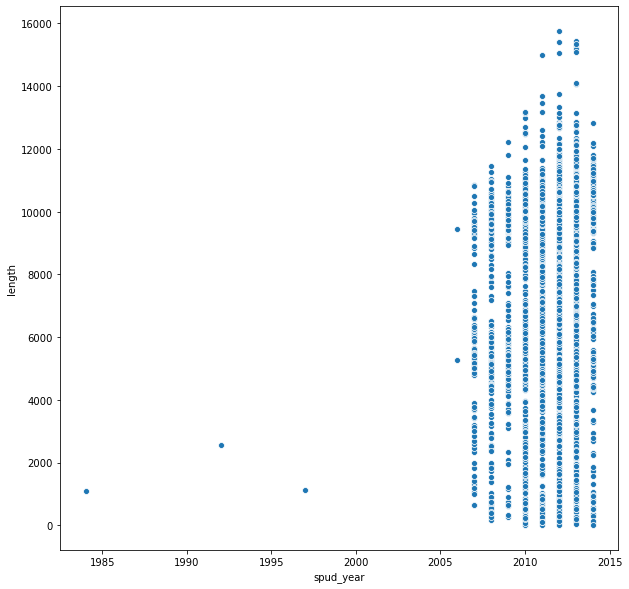

In [79]:
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(data=date_df, y="length", x="spud_year")

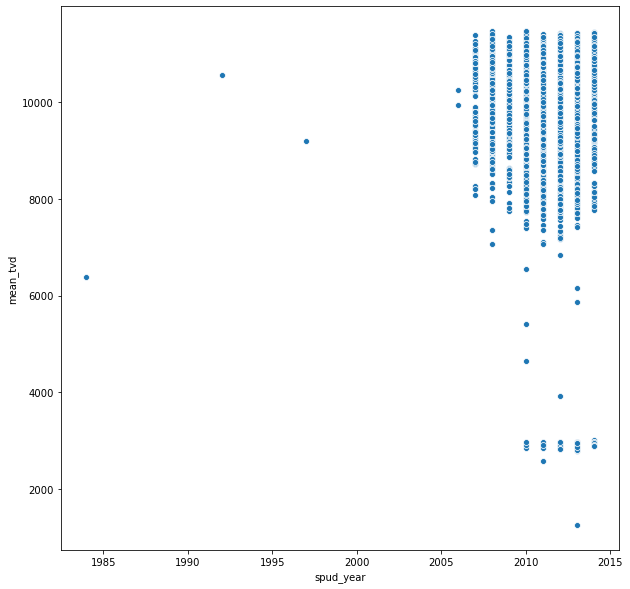

In [80]:
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(data=date_df, y="mean_tvd", x="spud_year")

In [81]:
date_df.query("spud_year < 2006")

,bakken_isopach_ft,bh_lat,bh_lng,choke_size,countyname,currentoperator,currentwellname,dfelev,fieldname,fileno,...,wellbore,wellstatus,welltype,length,prop_per_ft,fluid_per_ft,stage_spacing,range_tvd,shortest_dist,spud_year
api,,,,,,,,,,,,,,,,,,,,,
33053024160000,30.00,47.46,-103.64,nan,MCKENZIE,"EMERALD OIL, INC",FEDERAL 21-14HR,nan,FLAT TOP BUTTE,13468,...,HORIZONTAL RE-ENTRY,A,OG,2563.09,403.54,11.26,0.01,508.18,0.10,1992.00
33013011070000,70.00,48.74,-102.37,nan,BURKE,"PETRO HARVESTER OPERATING COMPANY, LLC",OPSETH 29-1,nan,SOUTH COTEAU,11259,...,HORIZONTAL RE-ENTRY,A,OG,1085.17,nan,0.18,0.00,186.11,0.01,1984.00
33007013860000,20.00,46.82,-103.38,nan,BILLINGS,"DENBURY ONSHORE, LLC",SOUTH FRYBURG 40-26,nan,FRYBURG,14713,...,HORIZONTAL RE-ENTRY,A,OG,1110.99,47.67,2.78,0.00,122.54,0.11,1997.00


In [82]:
date_df.query("wellbore in ['HORIZONTAL RE-ENTRY', 'DIRECTIONAL']").filter(["wellbore", "spud_date", "length", "stimulated_formation"]).sort_values("wellbore")

,wellbore,spud_date,length,stimulated_formation
api,,,,
33007015830000,DIRECTIONAL,2010-04-10,nan,madison
33089005680000,DIRECTIONAL,2007-04-07,nan,NaN
33025013510000,DIRECTIONAL,2011-05-28,nan,red river
33053043750000,DIRECTIONAL,2012-09-28,nan,red river
33053024160000,HORIZONTAL RE-ENTRY,1992-11-27,2563.09,bakken
33013011070000,HORIZONTAL RE-ENTRY,1984-10-30,1085.17,nesson
33023005530000,HORIZONTAL RE-ENTRY,2009-08-06,5734.45,NaN
33101004750000,HORIZONTAL RE-ENTRY,2008-06-23,7603.19,NaN
33007013860000,HORIZONTAL RE-ENTRY,1997-11-02,1110.99,tyler


In [83]:
date_df.query("wellbore == 'HORIZONTAL RE-ENTRY'").filter(["wellbore", "spud_date", "length", "stimulated_formation", target_col])

,wellbore,spud_date,length,stimulated_formation,production_liquid_180
api,,,,,
33053024160000,HORIZONTAL RE-ENTRY,1992-11-27,2563.09,bakken,40223.00
33013011070000,HORIZONTAL RE-ENTRY,1984-10-30,1085.17,nesson,nan
33023005530000,HORIZONTAL RE-ENTRY,2009-08-06,5734.45,NaN,18946.00
33101004750000,HORIZONTAL RE-ENTRY,2008-06-23,7603.19,NaN,nan
33007013860000,HORIZONTAL RE-ENTRY,1997-11-02,1110.99,tyler,nan
33053027480000,HORIZONTAL RE-ENTRY,2008-01-31,2945.31,NaN,21060.00


In [84]:
date_df.wellbore.value_counts()

HORIZONTAL             6519
HORIZONTAL RE-ENTRY       6
DIRECTIONAL               4
Name: wellbore, dtype: int64

## Production Data over time, for each well

In [85]:
inspect_df.query("production_liquid_90 > 0").shape

(6396, 58)

In [86]:
prod_df = (inspect_df.copy()
                   .filter(regex="production_liquid")
                   .query("production_liquid_30 > 0")
                   .rename(columns=lambda x: int(x.split("_")[-1]))
                   .drop([1825], axis=1)
                   .reset_index()
                   .melt(id_vars="api", value_name="cum_prod", var_name="ip_day")
                   .sort_values(["api", "ip_day"])
                   .reset_index(drop=True)
                   .assign(
                           ip_day=lambda x: x["ip_day"].astype(int),
                           cum_prod=lambda x: x["cum_prod"].astype(float),
                           day_diff=lambda x: x.groupby(["api"])["ip_day"].transform(pd.Series.diff),
                           prod_diff=lambda x: x.groupby(["api"])["cum_prod"].transform(pd.Series.diff),
                           prod_rate = lambda x: (x["prod_diff"] / x["day_diff"]).round(2)
                          )     
          )

In [87]:
prod_df.head()

,api,ip_day,cum_prod,day_diff,prod_diff,prod_rate
0,33007015740000,30,4829.00,nan,nan,nan
1,33007015740000,60,9223.00,30.00,4394.00,146.47
2,33007015740000,90,12745.00,30.00,3522.00,117.40
3,33007015740000,120,15051.00,30.00,2306.00,76.87
4,33007015740000,150,15975.00,30.00,924.00,30.80


In [88]:
well_ids = inspect_df.index.to_list()
well_ids[:10]

['33105034550000',
 '33053034020000',
 '33061026020000',
 '33089007540000',
 '33061021060000',
 '33025014870000',
 '33053031590000',
 '33105027640000',
 '33053033000000',
 '33061009490000']

In [89]:
def plot_well_curve(prod_df, well_id):
    sub_df = prod_df.query("api == @well_id")
    display(Markdown(f"## {well_id}"))
    fig, ax = plt.subplots(1, 2, figsize=(16, 5))
    ax[0].plot(sub_df["ip_day"], sub_df["cum_prod"])
    ax[1].plot(sub_df["ip_day"], sub_df["prod_rate"])
    plt.show()
    display(sub_df)

### Here is a normal-looking production curve

## 33013014020000

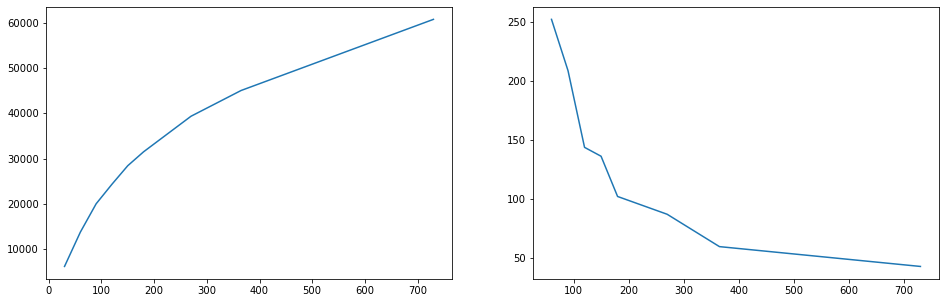

,api,ip_day,cum_prod,day_diff,prod_diff,prod_rate
945,33013014020000,30,6185.00,nan,nan,nan
946,33013014020000,60,13754.00,30.00,7569.00,252.30
947,33013014020000,90,20019.00,30.00,6265.00,208.83
948,33013014020000,120,24336.00,30.00,4317.00,143.90
949,33013014020000,150,28427.00,30.00,4091.00,136.37
950,33013014020000,180,31496.00,30.00,3069.00,102.30
951,33013014020000,270,39348.00,90.00,7852.00,87.24
952,33013014020000,365,45032.00,95.00,5684.00,59.83
953,33013014020000,730,60740.00,365.00,15708.00,43.04


In [90]:
well_oi = well_ids[700]
plot_well_curve(prod_df, well_oi)

### Here is an abnormal-looking production curve:
This is probably something that could be cleaned up to improve model accuracy.

## 33025012450000

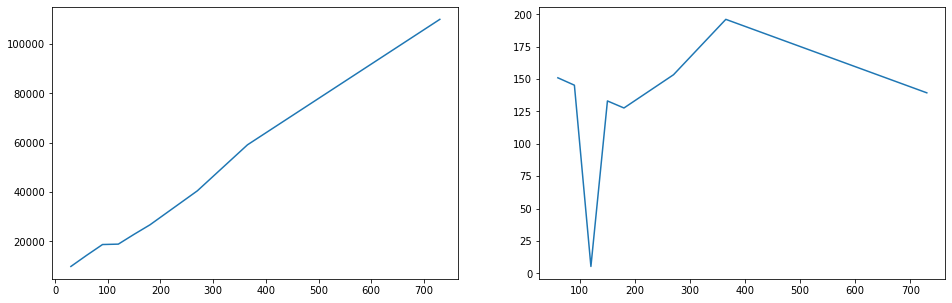

,api,ip_day,cum_prod,day_diff,prod_diff,prod_rate
9702,33025012450000,30,9813.00,nan,nan,nan
9703,33025012450000,60,14343.00,30.00,4530.00,151.00
9704,33025012450000,90,18702.00,30.00,4359.00,145.30
9705,33025012450000,120,18862.00,30.00,160.00,5.33
9706,33025012450000,150,22856.00,30.00,3994.00,133.13
9707,33025012450000,180,26687.00,30.00,3831.00,127.70
9708,33025012450000,270,40490.00,90.00,13803.00,153.37
9709,33025012450000,365,59123.00,95.00,18633.00,196.14
9710,33025012450000,730,110007.00,365.00,50884.00,139.41


In [91]:
well_oi = well_ids[500]
plot_well_curve(prod_df, well_oi)

<a name="paragraph7"></a>
# Preliminary model fitting

In [92]:
def normalize_formation(x):
    if x in {"bakken", "three forks"}:
        return x
    else:
        return np.nan

In [93]:
def normalize_formation_helper(df, primary_col, secondary_col):
    df = df.copy()
    fill_values = df[secondary_col].str.lower().apply(lambda x: normalize_formation(x))
    df["target_formation"] = df[primary_col].apply(lambda x: normalize_formation(x)).fillna(fill_values)
    df = pd.get_dummies(data=df, columns=["target_formation"], prefix="formation")
    df.drop([primary_col, secondary_col], axis=1, inplace=True)
    return df

In [94]:
target = "production_liquid_180"

In [95]:
def fill_median(df, cols=None):
    df = df.copy()
    
    if cols == None:
        cols = df.columns
    for col in cols:
        fill_value = df[col].median()
        df[col].fillna(value=fill_value, inplace=True)
        
    return df

In [96]:
model_features = foi + [target_col, "stimulated_formation", "producedpools"]

In [97]:
full_df = (clean_df.copy()
               .dropna(subset=[target])
               .filter(model_features)
               .pipe(normalize_formation_helper, "stimulated_formation", "producedpools")
               .pipe(fill_median) 
          )

In [98]:
full_df.columns

Index(['bakken_isopach_ft', 'choke_size', 'fluid_per_ft', 'legs', 'length',
       'mean_tvd', 'prop_per_ft', 'shortest_dist', 'stage_spacing',
       'total_lbs_proppant', 'total_num_stages', 'total_volume_bbls',
       'production_liquid_180', 'formation_bakken', 'formation_three forks'],
      dtype='object')

In [99]:
full_df.head()

,bakken_isopach_ft,choke_size,fluid_per_ft,legs,length,mean_tvd,prop_per_ft,shortest_dist,stage_spacing,total_lbs_proppant,total_num_stages,total_volume_bbls,production_liquid_180,formation_bakken,formation_three forks
api,,,,,,,,,,,,,,,
33105034550000,90.00,0.64,9.55,2.00,9450.58,10868.58,422.37,0.00,0.00,3991618.00,20.00,90232.00,48302.00,1,0
33053034020000,50.00,0.31,6.88,2.00,10073.98,10724.27,364.13,0.03,0.00,3668254.00,38.00,69347.00,58729.00,1,0
33061026020000,110.00,0.50,6.16,2.00,7544.78,9830.27,403.74,0.01,0.01,3046163.00,46.00,46463.00,17221.00,0,1
33089007540000,40.00,0.75,5.50,2.00,10043.79,10242.21,479.04,0.01,0.00,4811400.00,30.00,55196.00,44904.00,1,0
33061021060000,90.00,0.28,5.81,2.00,9867.18,9706.36,306.45,0.00,0.00,2872840.00,30.00,54812.00,104497.00,1,0


In [100]:
test, train = train_test_split(full_df)
train_X, train_y = mft.X_y_split(test, target=target)
test_X, test_y = mft.X_y_split(test, target=target)

In [101]:
gbr = GradientBoostingRegressor(learning_rate=0.01,
                                n_estimators=500, 
                                subsample = .7, 
                                max_depth =7, 
                                min_samples_split= 3, 
                                random_state=1984)

In [102]:
gbr.fit(train_X, train_y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.01, loss='ls', max_depth=7,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=3,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='auto',
                          random_state=1984, subsample=0.7, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

### Error metrics

In [103]:
 mse, mae, rmse, rrse = mft.eval_model(gbr, test_X, test_y, train_y)

y_hat = gbr.predict(test_X)

eval_df = (pd.concat([test_y.reset_index(), pd.Series(y_hat, name="pred").round(2)], axis=1)
           .set_index("api")
           .rename(columns={"production_liquid_180": "actual"})
           .assign(resid=lambda x: x["pred"] - x["actual"])
           .assign(perc_resid=lambda x: x["resid"] / x["actual"] * 100)
           .assign(abs_resid=lambda x: x["resid"].abs())
           .assign(abs_perc_resid=lambda x: x["abs_resid"] / x["actual"] * 100)
          )

mape = eval_df.abs_perc_resid.mean()

mape_adj = eval_df.abs_resid.mean() / eval_df.actual.mean() * 100

In [104]:
error_dict = {"mae ": mae, "rmse": rmse, "rrse": rrse, "mae": mae, "mape": mape, "adj_mape": mape_adj}

In [105]:
for name, val in error_dict.items():
    print(name, val.round())

mae  13196.0
rmse 17678.0
rrse 52.0
mae 13196.0
mape 33.0
adj_mape 22.0


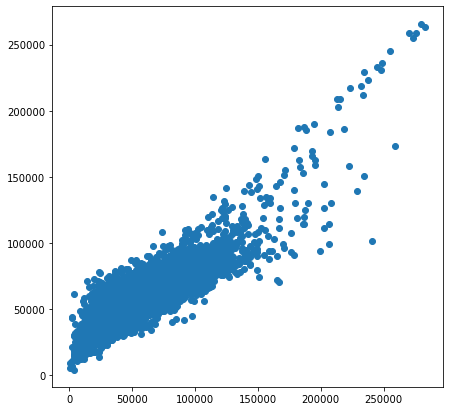

In [106]:
plt.subplots(figsize=(7, 7))
plt.scatter(data=eval_df, x="actual", y="pred")

### The model is clearly biased: it's overpredicting small values and underpredicting large values

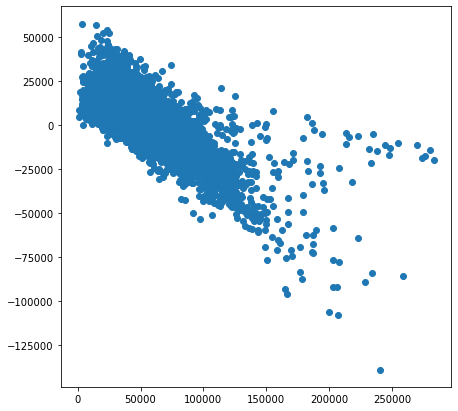

In [107]:
plt.subplots(figsize=(7, 7))
plt.scatter(data=eval_df, x="actual", y="resid")
# ax.h_lines(y=0, xmin=0, xmax=3000000)

In [108]:
train_X.columns.values

array(['bakken_isopach_ft', 'choke_size', 'fluid_per_ft', 'legs',
       'length', 'mean_tvd', 'prop_per_ft', 'shortest_dist',
       'stage_spacing', 'total_lbs_proppant', 'total_num_stages',
       'total_volume_bbls', 'formation_bakken', 'formation_three forks'],
      dtype=object)

In [109]:
feat_imp_df = mft.get_rig_df(gbr, train_X.columns.values)

In [110]:
feat_imp_df

,importance
feature,
legs,0.00
formation_bakken,0.01
formation_three forks,0.02
fluid_per_ft,0.03
prop_per_ft,0.03
total_num_stages,0.04
choke_size,0.05
stage_spacing,0.05
total_volume_bbls,0.06


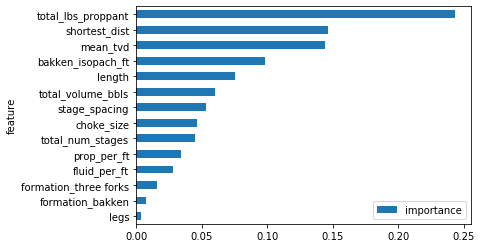

In [112]:
# This all makes sense
feat_imp_df.plot.barh()